In [1]:
import numpy as np 
from numpy import linalg as LA
import math 
from scipy.stats import unitary_group as ungp
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt

In [2]:
#DEFINING THE PAULI MATRICES
identity=np.eye(2)
sx=np.matrix([[0,1],[1,0]])
sy=np.matrix([[0,-1j],[1j,0]])
sz=np.matrix([[1,0],[0,-1]])

In [3]:
# ALL THE FUNCTIONS ARE HERE 

#gram schmidt decomp algorithm
def gram(v,ctxt_bas,A,b,K,Armsv):
    #incoming v is a list 
    D=len(ctxt_bas) #effective dimension
    v=np.matrix(v) #context vectors
    v=v.getH()
    
    v_ct=[] #terms of the context in the gram basis
    #v_ct is now a list now
    for v_k in ctxt_bas: 
        # we will make v_k normalised column vectors by design; by adding column vectors in the end
        
        coeff=v.getH()@v_k
        v_ct.append(coeff[0,0])  #The projection of the current context in the smaller space 
        v=v-coeff[0,0]*v_k
    
    if LA.norm(v)>.1**5: #numerical error
        v_ct.append(LA.norm(v))
        ctxt_bas.append(v/LA.norm(v))  # makes sure all basis vectors are normalised
        D=D+1 #we increase the effective dimension
        
        #We increase the dimensions of A_n and b_n
        A_n=np.identity(K*(D))*0
        A_n=np.matrix(A_n)
        b_n=np.zeros([K*(D),1])
        b_n=np.matrix(b_n)
        for k in range(K): 
            A_n[k*D:(k*D+D-1),k*D:(k*D+D-1)]=A[k*(D-1):(k*(D-1)+D-1),k*(D-1):(k*(D-1)+D-1)]
            b_n[k*D:(k*D+D-1),0]=b[k*(D-1):(k*(D-1)+D-1),0]
            A_n[k*D+D-1,k*D+D-1]=1
        
        A=A_n
        b=b_n
        
     
    ArmsvG=[]
    for arms in Armsv: 
        arms=np.matrix(arms)
        arms=arms.getH()
            
        for v in ctxt_bas:  
            
            ArmsvG.append((v.getH()@arms)[0,0])
    ArmsvG=np.matrix(ArmsvG)
    ArmsvG=ArmsvG.getH()  #ArmsvG is one long vector, basically theta*
        
    v_ct=np.matrix(v_ct)
    v_ct=v_ct.getH()   
    
    return [ctxt_bas,A,b,v_ct,D,ArmsvG]

#Functions concatenate vectors - for storing all the b- vectors as one long vector.
def concat(K,arms,x):
    D=np.size(x)
    c_at=np.zeros([K*D,1])
    for i in range(np.size(x)):
        c_at[arms*np.size(x)+i,0]=x[0,i]
    c_at=np.matrix(c_at)
    return c_at

# function for random hamiltonians. Currently just ising, later will add others. Arguement in function is for chosing
# the hamiltonian family.


def linUCBGram_ising(T,t_rate,K,n,Armsv): #inputs T:number of rounds, t_rate: how often we plot K number of arms n qubits Armsv vecotr with all arms to learn
    
    Armsvp=Armsv
    Armsv=np.matrix(Armsv)
    #Armsv=Armsv.getH()
    
    alpha=np.sqrt(0.5*np.log(2*T*K)-.5*np.log(.01))     
    ctxt_ch=[] #we store the parameters that define the hamiltonian at each round
    Arms_alg=[] #arms that the algorithm picks at each round, we store the label
    Arms_opt=[] #label for the optimal arm at each round
    Arms_alg_label=[] # phase label for the alg
    Arms_opt_label=[] # optimal phase label
    a_max=0 #dummy variable to store the label picked by the algorithm
    a_maxR=0 #dummy variable to store the label of the optimal arm
    Regretv=[] #we store the instantaneous regret at each time step t
    Rewards=[] #we store the reward at each time step t
    regret=0 #dummy variable that is updated at t_rate
    Pr=[] 
    ctxt_bas=[] #set of orthoganl basis that Grahm schmidt is giving
    D=0 #effective dimension
    regret_list=[] #cumulative regret using t_rate
    A=np.identity(K*0) #desing matrix
    b=np.matrix([]) #sum reward per arm
    b=b.getH() #we need column vector
    for t in range(T):
        #THIS IS THE RANDOM HAMILTONIAN GENERATING FUNCTION, CHANGE THE ARGUEMENT TO HAVE DIFFERENT FAMILIES
        j1=np.random.uniform(-10,10, size=1)    
        j0=np.random.uniform(-4,4, 1)*0+1 #to match date type
        j2=np.random.uniform(-10,10, size=1)       
        v=[-j1]*n+[j0]*n+[-j2]*n #vector corresponding to the hamiltonian
        v=np.matrix(v) 
        v=v.getH()
        #[v,j1,j2]=randHam(1)     # 1 is just an arguement I added, in case you want to modularise the code later.
        ctxt_ch.append([j1,j2]) #we store the parameters 
        
        [ctxt_bas,A,b,x,D,ArmsvG]=gram(v,ctxt_bas,A,b,K,Armsv)  
        #LATTIMORE ALPHA
        alpha=(1+ np.sqrt(K*D*np.log(1+t*36/(K*D))-2*np.log(.01)))        

        ArmsvGm=np.matrix(ArmsvG) #real arms 
        if t==0: #DEFINE AT THE BEGGINING!!!!!!!!!!!!!!!!!!!!!!!
            A=np.identity(K)
            b=np.zeros([K,1])
            A=np.matrix(A)
            b=np.matrix(b)
        #const=np.sqrt(np.trace(ArmsvGm.getH()@ArmsvGm))
        
        x=x.getH()     # context in grahm schmidt is now a column vector 
        
        #theta=LA.inv(A)@b
        c_max=np.zeros([K*D,1]) #vector corresponding to the context 00000 context 0000
        c_max=np.matrix(c_max)
        c_maxR=np.zeros([K*D,1]) # vector correspoding to context 00000 context but for theoptimal arm
        c_maxR=np.matrix(c_max) 
        ucb_max=-100000 #dummy variable to put the estimated mean with over confidence for the one that the algorithm picks
        
        for a in range(K):
            c_at=concat(K,a,x) #deconcadenating
            A_n=(A[a*D:(a+1)*D,a*D:(a+1)*D]).copy()
            b_n=(b[a*D:(a+1)*D,0]).copy()
            theta_n=LA.inv(A_n)@b_n #the estimate for arm a 
            
            ucb=x@theta_n+alpha*np.sqrt(x@LA.inv(A_n)@x.getH())/2 #*const
            if ucb>ucb_max:
                ucb_max=ucb
                c_max=c_at
                a_max=a
        Arms_alg.append(a_max)
        #FOR THE CLASSIFIER REGRET IT DEPENDS ON THE PARTICULAR ORDERING
        if a_max<K/2:
            Arms_alg_label.append(0)
        else:
            Arms_alg_label.append(1)
    #--------------------------------------------------------------next, Regret calculation---------------------
        expR_max=-100000 #MAXIMAL EXPECTED REWARD
        for a in range(K):
            c_at=concat(K,a,x)  
              
            rR=(-ArmsvG.getH()@c_at)[0,0] #EXPECTED REWARD FOR EACH ARM MINUS BECAUSE LOW ENERGY
            
            if rR>expR_max:
                expR_max=rR
                c_maxR=c_at
                a_maxR=a
        Arms_opt.append(a_maxR)
        #For the classification
        if a_maxR<K/2:
            Arms_opt_label.append(0)
        else:
            Arms_opt_label.append(1)

        #reward=np.random.binomial(size=1, n=1, p=pr)
        #reward=sampler_ising(a_max,context[t],prob_grid,eigvalN)
        #tuning alpha pagemark
        reward=-bernMeas(v,Armsvp,a_max)
        Rewards.append(reward)
        #use the varible corresponding to optimal expected reward
        regret=np.real((-ArmsvG.getH()@c_maxR)[0,0]-(-ArmsvG.getH()@c_max)[0,0])*2**n
       
        Regretv.append(np.real(regret))
        A+=c_max@c_max.getH()
        b+=reward[0]*c_max
        if t%t_rate==0: 
            
            regret_list.append(sum(Regretv))
    #print(Arms_alg,Arms_opt)
    #print(D,ArmsvG,ctxt_bas)
    return [regret_list,Arms_alg,Arms_opt,ctxt_ch]

def clustHam(j1,j2):
    # Define Hamiltonian using Qibo symbols
    # ZZ terms
    symbolic_ham = -j1*sum(X(i) * X((i + 1)%n) for i in range(n))
    # periodic boundary condition term
    symbolic_ham -=j2*sum(X((i-1)%n)*Z(i%n) * X((i + 1)%n) for i in range(n))
    # X terms
    symbolic_ham += sum(Z(i) for i in range(n))

    # Define a Hamiltonian using the above form
    ham = hamiltonians.SymbolicHamiltonian(symbolic_ham)
    # This Hamiltonian is memory efficient as it does not construct the full matrix
    #v=np.matrix(ham.eigenvectors()[0])
    return ham
def clustHam0(j1,j2):
    # Define Hamiltonian using Qibo symbols
    # ZZ terms
    symbolic_ham = -j1*sum(X(i) * X((i + 1)%n) for i in range(n))
    # periodic boundary condition term
    symbolic_ham -=j2*sum(X((i-1)%n)*Z(i%n) * X((i + 1)%n) for i in range(n))
    # X terms
    #symbolic_ham += 0*sum(Z(i) for i in range(n))

    # Define a Hamiltonian using the above form
    ham = hamiltonians.SymbolicHamiltonian(symbolic_ham)
    # This Hamiltonian is memory efficient as it does not construct the full matrix
    #v=np.matrix(ham.eigenvectors()[0])
    return ham

def bernMeas(v,Armsv,k): #v is the context vector, k is the arm that we are interested
    random_reward=0
    for i in range(len(Armsv[k])): #we use just the k arm
        pr=(2**n*Armsv[k][i]+1)/2
        
        random_reward+=v[0,i]*(2*np.random.binomial(size=1,n=1,p=pr)-1)
    return random_reward
        
        
        

In [4]:
def linOpt_ising(T,t_rate,K,n,Armsv):
    
    Armsv=np.matrix(Armsv)
    #Armsv=Armsv.getH()
    
    alpha=np.sqrt(0.5*np.log(2*T*K)-.5*np.log(.01))    
    ctxt_ch=[]
    Arms_alg=[]
    Arms_opt=[]
    Arms_alg_label=[]
    Arms_opt_label=[]
    a_max=0
    a_maxR=0
    Regretv=[]
    Rewards=[]
    regret=0
    Pr=[]
    ctxt_bas=[]
    D=0
    regret_list=[]
    A=np.identity(K*0)*3
    b=np.matrix([])
    b=b.getH()
    for t in range(T):
        #THIS IS THE RANDOM HAMILTONIAN GENERATING FUNCTION, CHANGE THE ARGUEMENT TO HAVE DIFFERENT FAMILIES
        j1=np.random.uniform(-4,4, 1)    
        j0=np.random.uniform(-4,4, 1)*0+1  
        j2=np.random.uniform(-4,4, size=1)       
        v=[-j1]*n+[j0]*n+[-j2]*n
        v=np.matrix(v)
        v=v.getH()
        #[v,j1,j2]=randHam(1)     # 1 is just an arguement I added, in case you want to modularise the code later.
        ctxt_ch.append([j1,j2])
        
        [ctxt_bas,A,b,x,D,ArmsvG]=gram(v,ctxt_bas,A,b,K,Armsv)  
        #LATTIMORE ALPHA
        alpha=(1+ np.sqrt(K*D*np.log(1+t*36/(K*D))-2*np.log(.01)))/80   

        ArmsvGm=np.matrix(ArmsvG)
        if t==0: 
            A=np.identity(K)
            b=np.zeros([K,1])
            A=np.matrix(A)
            b=np.matrix(b)
        #const=np.sqrt(np.trace(ArmsvGm.getH()@ArmsvGm))
        
        x=x.getH()     # context is now a column vector 
        
        #theta=LA.inv(A)@b
        c_max=np.zeros([K*D,1])
        c_max=np.matrix(c_max)
        c_maxR=np.zeros([K*D,1])
        c_maxR=np.matrix(c_max)
        ucb_max=-100000
        ucbL=[]
        
     
    #--------------------------------------------------------------next, Regret calculation---------------------
        expR_max=-100000
        for a in range(K):
            c_at=concat(K,a,x)  
              
            rR=(-ArmsvG.getH()@c_at)[0,0]
            
            if rR>expR_max:
                expR_max=rR
                c_maxR=c_at
                a_maxR=a
        Arms_opt.append(a_maxR)
        if a_maxR<K/2:
            Arms_opt_label.append(0)
        else:
            Arms_opt_label.append(1)

        #reward=np.random.binomial(size=1, n=1, p=pr)
        #reward=sampler_ising(a_max,context[t],prob_grid,eigvalN)
        reward=np.random.normal((-ArmsvG.getH()@c_max)[0,0], 1, 1)
        Rewards.append(reward)
        
 
    #print(Arms_alg,Arms_opt)
    #print(D,ArmsvG,ctxt_bas)
    return [Arms_opt,ctxt_ch]

Ising Model Hamiltonians as contexts 

$H=\sum_{i=1}^{N}c(Z_i \otimes Z_{i+1}+hX_i)$

In [5]:
import qibo
#qibo.set_backend("tensorflow")
from qibo.models import Circuit
from qibo import gates
from qibo.hamiltonians import TFIM
from qibo.hamiltonians import XXZ
from qibo import hamiltonians
from qibo.symbols import X, Z, Y


In [10]:
# TO CHANGE NO. OF QIBITS, CHANGE N. PAULI_BAS IS NEAR NEIGHBOUR TERMS FOR PAULI BASIS
n=7      # TO INCREASE NO. OF QUBITS, JUST CHANGE n.
pauli_bas=[]
for i in range(n):
    p=1
    pvec=[]
    for j in range(n):
        if j!=(i%(n)) and j!=((i+1)%(n)):
            p=np.kron(p,np.eye(2))
            
        else: 
            p=np.kron(p,sx)
            pvec.append("sx")
            pvec.append(j)

    pauli_bas.append(p)
    
# MAKING A LIST OF SUCH PAULI CHAINS
for i in range(n):
    p=1
    pvec=[]
    for j in range(n):
        if j!=(i%(n)):
            p=np.kron(p,np.eye(2))
        else: 
            p=np.kron(p,sz)
            pvec.append("sz")
            pvec.append(j)
    pauli_bas.append(p)
      
for i in range(n):
    p=1
    pvec=[]
    for j in range(n):
        if j==(i-1)%n or j==(i+1)%n: 
            p=np.kron(p,sx)
            pvec.append("sx")
            pvec.append(j)
        elif j==i%n: 
            p=np.kron(p,sz)
            pvec.append("sz")
            pvec.append(j)
        else: 
            p=np.kron(p,np.eye(2))
    pauli_bas.append(p)
       
        
    


In [11]:
from numpy.linalg import matrix_rank


In [13]:
# SELECTING ARMS. K IS THE NUMBER OF ARMS. HALF OF THEM ARE RANDOMLY CHOSEN FROM EACH PHASE TRANSITION AREA.

K=5                         # TO CHANGE NO. OF ARMS, JUST CHANGE K.
Armsv=[]
D=2**n 
eps=1
arms=[]
coords=[[0,-1],[3,0],[-3,0],[0,3],[0,0]]
for i in range(K):
    j1=coords[i][0]
    j2=coords[i][1]
    H=clustHam0(j1,j2)   
    if i==4:
        H=-1*clustHam(j1,j2)        
    v=np.matrix(-H.eigenvectors())[:,0]
    
    rho= ((1-eps)*np.identity(2**n)/(2**n)+eps*v@v.getH()) 
    rho=np.matrix(rho)
    arms.append(rho) 
#create vectors for each rho 
    v=[]
    for p in pauli_bas:
        v.append(-(np.trace(rho@p))/(2**(n)))   # CHECK NORMALISATION
    
    Armsv.append(v)


[Qibo 0.1.8|WARNING|2023-07-02 15:24:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.8|WARNING|2023-07-02 15:24:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.8|WARNING|2023-07-02 15:24:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.8|WARNING|2023-07-02 15:24:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.8|WARNING|2023-07-02 15:24:37]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [14]:
# SELECTING ARMS. K IS THE NUMBER OF ARMS. HALF OF THEM ARE RANDOMLY CHOSEN FROM EACH PHASE TRANSITION AREA.

n=6 # number of qubits
K=5  #number of arms                     
Armsv=[] #vectors for the arms, all of them
D=2**n #Hilbert space dimension
eps=1 #this denotes purity, between 0 and 1
#arms=[] 
coords=[[0,-1,0],[1,0,0],[-1,0,0],[0,1,0],[0,0,-1],[0,0,1]] #coordinates for picking the arms the extra one if for the sigmax term

#Here we generate the arms to learn 
# We do not include the identity term because it is not used during the computations
for i in range(K):
    j1=coords[i][0]
    j2=coords[i][1]
    j0=coords[i][2]
 
    v=[0]*(3*n) #store all the vector corresponding to each arm, dummy vector
    for i in range(n):
        v[i]=(j1/(2**(n)))   # CHECK NORMALISATION
    for i in range(n,2*n):
        v[i]=(j0/(2**(n)))    # CHECK NORMALISATION
    for i in range(2*n,3*n):
        v[i]=(j2/(2**(n)))   # CHECK NORMALISATION    
    Armsv.append(v)


In [15]:
ArmsvM=np.matrix(Armsv) 
np.sqrt(np.trace(ArmsvM.getH()@ArmsvM)),K

(0.0855816496101822, 5)

EXECUTION SECTION

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


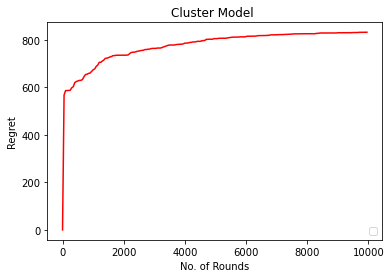

In [17]:
T=10000          # No. of rounds pagemark
t_rate=50         # Frequency of time stamps in the plot.
sample_size=1     # no. of samples we average over. 

# SETTING T_ROUNDS FOR THE TIME LABELS.SOLE PURPOSE IS FOR PLOTTING, NOT INVOLVED IN ALGORITHM.
t_rounds=[] #list of time steps for the plot
for i in range(0,T,t_rate):
    t_rounds.append(i)
    
# regret_list FOR STORING VALUES OF EACH 
regret_list=[0]*int(T/t_rate) #expected regret
classreg_list=[0]*int(T) #classifier regret

for ss in range(sample_size):
    [reg_list,Arms_alg,Arms_opt,ctxt_ch]=linUCBGram_ising(T,t_rate,K,n,Armsv)
    for i in range(len(regret_list)):
        regret_list[i]+=reg_list[i]/sample_size #be careful regret and reg list not the same

# NOW, PLOTTING        
plt.plot(t_rounds,regret_list, 'r')

#plt.axis([0, 6, 0, 20])
plt.xlabel("No. of Rounds")
plt.ylabel("Regret")
plt.legend(loc="lower right")
plt.title("Cluster Model ")
plt.show()

array([1.04158743])

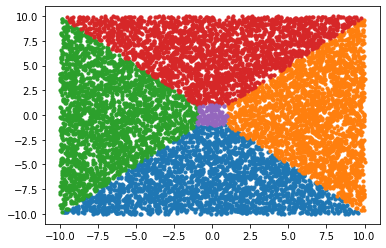

In [18]:
x=[]
for a in range(6): 
    Rounds=int(T)
    listj1=[]
    listj2=[]
    for tr in range(0,Rounds):        
        if Arms_opt[tr]==a:
            if a==3:
                x.append(ctxt_ch[tr][1])
            listj1.append(ctxt_ch[tr][0])
            listj2.append(ctxt_ch[tr][1])
    plt.scatter(listj1,listj2,10)
min(x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


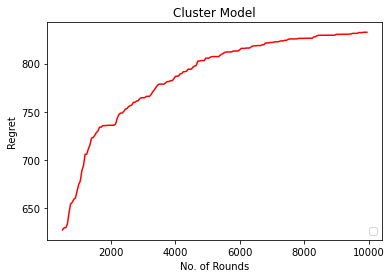

In [19]:
len(t_rounds)
plt.plot(t_rounds[10:],regret_list[10:], 'r')

#plt.axis([0, 6, 0, 20])
plt.xlabel("No. of Rounds")
plt.ylabel("Regret")
plt.legend(loc="lower right")
plt.title("Cluster Model")
plt.show()

Observe the plot above. It is in this region that hard learning happens. Need to discuss in paper.